This notebook demonstrates the task of image classification, in this case a classification of: vortex and no vortex presence. The notebook includes the fine-tuning (training phase), testing and inference on a dataset of satellite images containing waterbodies in Angola. The fine-tuning is performed on a pre-trained CNN.

 The notebook follows these steps:

*   General setup of DL environment in Google Colab (coupled to your Google Drive)
*   All settings
*   Fine-tuning the model with a training dataset
*   Testing the fine-tuned model
*   Inference: classification of vortices




# General setup

In [1]:
!pip install --upgrade geopandas

# Imports
import pathlib
import numpy as np
import os
import sys
import datetime
import itertools
import tensorflow_hub as hub
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import geopandas as gpd
from sklearn.metrics import confusion_matrix, accuracy_score

!git clone https://github.com/Argantonio65/OpticalMeasurements.git

print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
Cloning into 'OpticalMeasurements'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 160 (delta 89), reused 144 (delta 77), pack-reused 0
Receiving objects: 100% (160/160), 16.71 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (89/89), done.
2.15.0


In [2]:
# The following line of code is a shell command executed within the notebook. It uses the '!' prefix to run a command as if it were in the terminal.
!nvidia-smi

# The 'nvidia-smi' command stands for NVIDIA System Management Interface. It is used to query and manage NVIDIA GPU devices.
# Running this command displays information about the GPUs on your system, including utilization, memory usage, driver version, and more.

Thu Jul 18 15:58:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   33C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
!gcloud config set project deepscale-11210295-013

Updated property [core/project].


In [6]:
!mkdir -p /content/dataset/
!gsutil -m cp -r gs://classification_example/dataset_vortexBinary_v0/* /content/dataset/

Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1001.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1011.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1021.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1031.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1041.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1061.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1101.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1121.png...
Copying gs://classification_example/dataset_vortexBinary_v0/no_vortex/images_q30_148on_light02 - 1131.png...
Copying gs://classi

In [7]:
# Set the AUTOTUNE option for automatic optimization and print the Tensorflow version
AUTO = tf.data.experimental.AUTOTUNE
print(f"Tensorflow version that is currently being used: {tf.__version__}")

Tensorflow version that is currently being used: 2.15.0


In [8]:
# Initialize TPU if data is stored in the cloud
tpu = None

if tpu:
  # If TPU is initialized, shut down the TPU system
  tf.tpu.experimental.shutdown_tpu_system(tpu)

try:
  # Attempt to detect and initialize a TPU
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
  # If no TPU is found, fall back to default strategy for CPU or single GPU
  strategy = tf.distribute.get_strategy() # default strategy for CPU and single GPU

# Settings

#### Paths and files

In [9]:
# Google Drive directory that stores the downloaded data and scripts (later changeo to name repository folder: image_classification)
dir_gdrive = r'/content/'

# Datasets, model and scripts
dir_data = f'{dir_gdrive}/dataset'
dir_model = f'{dir_gdrive}/01_model'
dir_scripts = f'{dir_gdrive}/02_src'
sys.path.append(dir_scripts)

# Print system path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content//02_src']

#### Model (pre-trained CNN)

In [10]:
model_name = "efficientnetv2-xl-21k"
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"

#### Training

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1.5 / 255)
do_data_augmentation = True

IMAGE_SIZE = (512, 512) # this is the image shape required for the keras model (or what): so if the images have different shapes (that is the case for the vortex images. TODO: the images need to be reshaped to (512, 512); there is a keras function for this)
BATCH_SIZE = 16         # TODO: check with Antonio: he used batch size 20 for the testing and inference
EPOCHS = 10

drop_out_rate = 0.3
learning_rate = 0.005
momentum = 0.9
label_smoothing = 0.1
metrics = ['accuracy']


# Fine-tune model

## Training

### Build dataset

In [42]:
def extract_labels(dataset):
    labels = []
    for _, label in tqdm(dataset):
        labels.append(label.numpy())
    return np.concatenate(labels, axis=0)

def build_training_dataset(dir_data, subset, image_size, batch_size):
  ds = tf.keras.preprocessing.image_dataset_from_directory( #write: expects data in specific format (folder names)
      dir_data,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      seed=123,
      image_size=image_size,
      batch_size=1)

  # Extract labels from the training dataset (useful to created balancing weights)
  labels = extract_labels(ds)

  ds_class_names = tuple(ds.class_names)
  ds_size = ds.cardinality().numpy()
  ds = ds.unbatch().batch(batch_size)
  if subset == "training":
    ds = ds.repeat()
  return ds, ds_class_names, ds_size, labels

def augment_data(do_data_augmentation, preprocessing_model):
  if do_data_augmentation:
    # preprocessing_model.add(
    #     tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(
        tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
        tf.keras.layers.RandomFlip(mode="horizontal"))
    # preprocessing_model.add(
    #     tf.keras.layers.RandomFlip(mode="vertical"))
  return preprocessing_model

In [43]:
# Training data
dir_data_training = dir_data
ds_train_r, class_names, ds_train_size, train_labels = build_training_dataset(dir_data_training, "training", IMAGE_SIZE, BATCH_SIZE)
preprocessing_model = tf.keras.Sequential([normalization_layer])
preprocessing_model = augment_data(do_data_augmentation, preprocessing_model)
ds_train = ds_train_r.map(lambda images, labels:(preprocessing_model(images), labels))

# Validation data
ds_val, class_names, ds_val_size, _ = build_training_dataset(dir_data_training, "validation", IMAGE_SIZE, BATCH_SIZE)
ds_val = ds_val.map(lambda images, labels:(normalization_layer(images), labels))

Found 271 files belonging to 2 classes.
Using 217 files for training.


100%|██████████| 217/217 [00:01<00:00, 131.58it/s]


Found 271 files belonging to 2 classes.
Using 54 files for validation.


100%|██████████| 54/54 [00:00<00:00, 117.66it/s]


In [44]:
### CREATE A class weights dictionary to deal with imbalanced datasets

from sklearn.utils import class_weight

y_values = np.argmax(train_labels, axis = 1) # train labels are supplied as [[0,1], [1,0], [1,0]...] where the index of one indicates the class. argmax resuls in the label index vector [0,1,1...]

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(y_values), y=y_values)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [45]:
def plot_training_data(ds, number_of_images):
  ncols = 4
  nrows = number_of_images // ncols + 1
  fig = plt.figure(figsize=(15, 15))
  for images, labels in ds.take(1):
    for i in range(number_of_images):
      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(images[i].numpy())
      plt.title(np.argmax(labels[i].numpy()))
      plt.axis("off")
  return fig

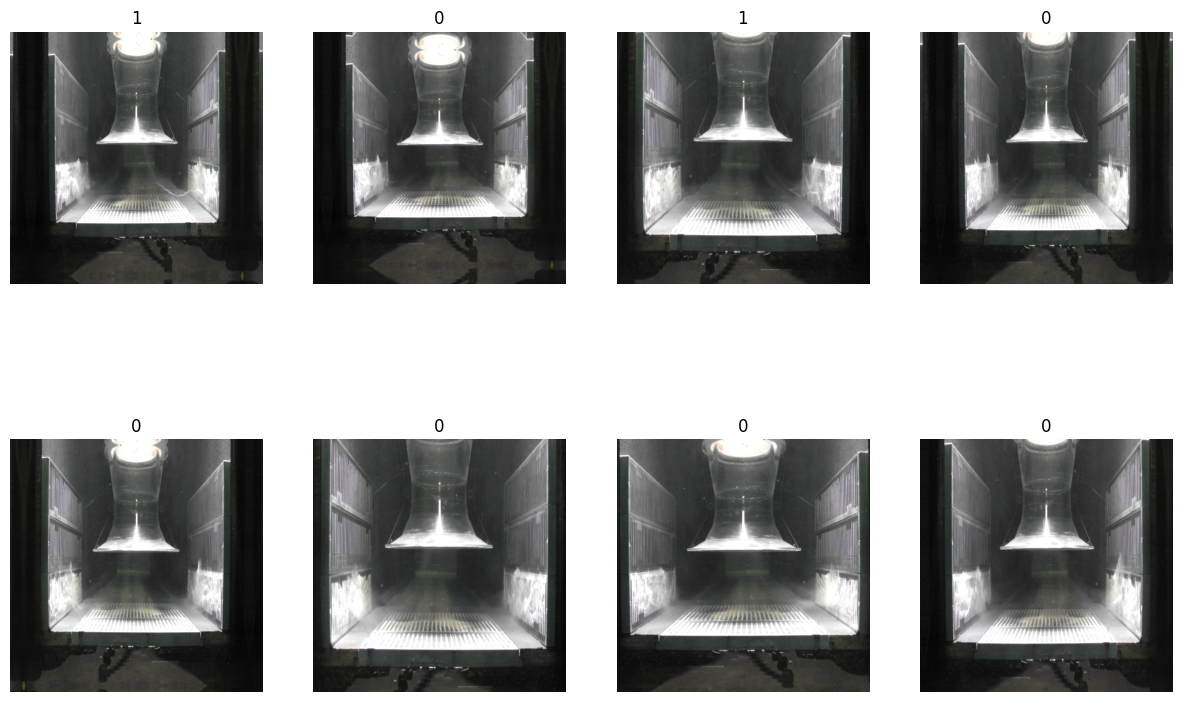

In [46]:
# Plot a few images from the validation dataset to check
fig_val = plot_training_data(ds_train, 8)

### Build model

In [16]:
# Composition of the model of different layers (input layer, original encoder layers, dense layers that are trained with the satellite imagery dataset)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=drop_out_rate),
    tf.keras.layers.Dense(len(class_names),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

# Configure the model for training by specifiying the optimizer (Stochastic Gradient Descent), loss function and metrics to be used
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=label_smoothing),
  metrics=metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 207618394 (792.00 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 207615832 (791.99 MB)
_________________________________________________________________


### Train model

In [47]:
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                         min_delta=0.001,
                                         verbose=1,
                                         patience=3,
                                         restore_best_weights=False)

hist = model.fit(
    ds_train,
    epochs=EPOCHS,
    callbacks=[callback],
    steps_per_epoch=ds_train_size // BATCH_SIZE,
    validation_data=ds_val,
    validation_steps=ds_val_size // BATCH_SIZE,
    class_weight=class_weights_dict).history

Epoch 1/10
13/13 [==============================] - 15s 1s/step - loss: 9.9605 - accuracy: 0.4183 - val_loss: 2.6752 - val_accuracy: 0.8542
Epoch 2/10
13/13 [==============================] - 13s 1s/step - loss: 5.9819 - accuracy: 0.5274 - val_loss: 0.6602 - val_accuracy: 0.8958
Epoch 3/10
13/13 [==============================] - 13s 1s/step - loss: 6.2981 - accuracy: 0.5274 - val_loss: 2.8347 - val_accuracy: 0.1250
Epoch 4/10
13/13 [==============================] - 13s 1s/step - loss: 4.8024 - accuracy: 0.4826 - val_loss: 8.5938 - val_accuracy: 0.1458
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 7.8403 - accuracy: 0.5373 - val_loss: 2.2548 - val_accuracy: 0.1667
Epoch 6/10
13/13 [==============================] - 13s 1s/step - loss: 6.0576 - accuracy: 0.4925 - val_loss: 1.0341 - val_accuracy: 0.5208
Epoch 7/10
13/13 [==============================] - 13s 1s/step - loss: 5.2714 - accuracy: 0.5622 - val_loss: 1.1331 - val_accuracy: 0.8542
Epoch 7: early stopp

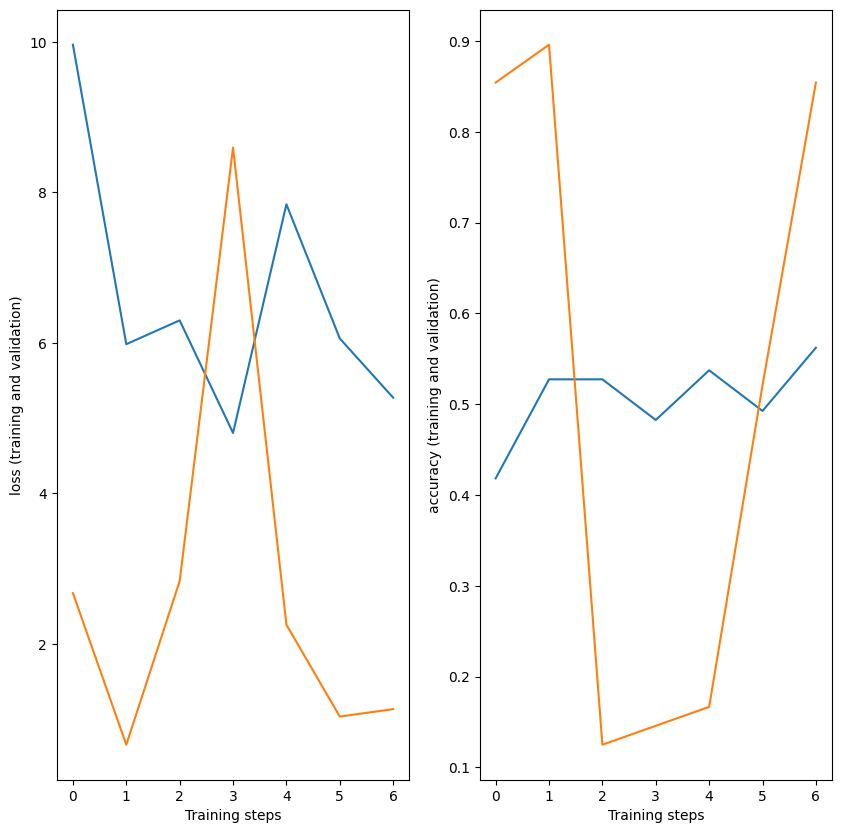

In [49]:
def plot_training_results(hist):
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    for i, x in enumerate(['loss', 'accuracy']):
        axes[i].set_ylabel(f'{x} (training and validation)')
        axes[i].set_xlabel("Training steps")
        axes[i].plot(hist[x])
        axes[i].plot(hist[f'val_{x}'])
    # axes[0].set_ylim([0,1])
    # axes[1].set_ylim([0,2])
    return fig

fig = plot_training_results(hist)

In [50]:
def save_model(model, dir_model, name_model, hist):
    full_path_model = os.path.join(dir_model, f'model_{name_model}_finetuned.h5')
    model.save(full_path_model)
    hist_df = pd.DataFrame(hist)
    hist_df.to_csv(os.path.join(dir_model, f'hist_{name_model}_finetuned.csv'))
    return  print(f'Your fine-tuned model is saved as: {full_path_model}')

save_model(model, dir_model, model_name, hist)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Your fine-tuned model is saved as: /content//01_model/model_efficientnetv2-xl-21k_finetuned.h5


## Testing

### Build dataset

In [51]:
dir_data_testing = os.path.join(dir_data, 'testing') # dir_data_testing = f'{dir_gdrive}/testing3class'

ds_test = tf.keras.utils.image_dataset_from_directory(
    dir_data_testing,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, #25?
    shuffle = True
)

ds_test = ds_test.map(lambda images, labels:(normalization_layer(images), labels))

NotFoundError: Could not find directory /content//dataset/testing

### Test model

In [ ]:
# Load fine-tuned model
# model = keras.models.load_model(os.path.join(dir_model, f'{model_name}_finetuned.h5'),
#        custom_objects={'KerasLayer':hub.KerasLayer})
model = keras.models.load_model(r'/content/drive/MyDrive/AngolaTrainingData/model_EffNetV2_retrainedAngola_3class.h5',
       custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from testing import test_model

labels_test, predictions_test = test_model(model, ds_test)

acc = accuracy_score(labels_test, predictions_test)
cm = confusion_matrix(labels_test, predictions_test)

print(f"Accuracy: {acc}")
print(f"Confusion matrix: \n{cm}")

In [ ]:
from plot import plot_test_results

fig = plot_test_results(model, ds_test)

# Inference

### Build dataset

In [ ]:
from inference import get_img_ids

dir_data_inference = os.path.join(dir_data, 'inference') # dir_data_inference = f'{dir_gdrive}/AngolaPNGsZoom'

ds_inf = tf.keras.utils.image_dataset_from_directory(
    dir_data_inference,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, #20?
    shuffle = False,
    label_mode=None,
    labels=None)

img_ids = get_img_ids(ds_inf)

ds_inf = ds_inf.map(lambda images:(normalization_layer(images)))

### Inference

In [ ]:
predictions = model.predict(dataset)
y_pred = np.argmax(predictions, axis = 1)

In [ ]:
# Show some results of the inference
from inference import plot_inference_results

fig = plot_inference_results(model, ds_inf)

In [ ]:
# Link the waterbodies in the images to the coordinates of the blobs in the geojson file and save to a new geojson file
from inference import link_waterbodies_coordinates, save_prediction_geojson

data_coord = gpd.read_file(os.path.join(dir_data, f'{filename_geojson}.geojson'))
pred_coord = linke_waterbodies_coordinates(img_ids, y_pred, data_coord)
save_prediction_geojson(pred_coord, dir_data, filename_geojson)